# Aula - Balanceamento de Datasets - Tera
### Marcus Oliveira da Silva

* Linkedin: [marcuos](https://www.linkedin.com/in/marcuos/)
* Dataset utilizado: [lending-club-clean](https://www.kaggle.com/datasets/marcusos/lending-club-clean)


**Libs utilizadas:**

* lightgbm
* scikit-learn
* pyarrow (Feather)
* imblearn
* pandas
* seaborn


Neste notebook, será abordado o tema de balanceamento de datasets, com o objetivo de mostrar como lidar com datasets desequilibrados e como utilizar técnicas para torná-los mais equilibrados. Utilizaremos como exemplo o dataset "Lending Club Clean" disponível no Kaggle. Ao final, espera-se que o aluno tenha uma noção clara de como lidar com datasets desequilibrados e como utilizar técnicas de balanceamento.

**Referências**
* [Plot Precision Recall Example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py)

## O que veremos hoje
**Bloco 1**
- Case e contexto de negócio
- Revisão do Preicision e do Recall
- Curva do PR e PR AUC

**Bloco 2**
- Carregando e limpando o dataset
- Pre-processamento dos dados
- Implementação do modelo

**Bloco 3**
- Class weight e hiperparâmetros
- Resampling
- Under e Over sampling
- Smote

**Bloco 4**
- Comparando os modelos
- Dúvidas

## Contexto Analítico

A empresa LendingClub fornece empréstimos P2P. Os investidores são responsáveis por suas próprias decisões sobre empréstimos.

O objetivo é identificar padrões que indicam se uma pessoa tem probabilidade de inadimplência, o que pode ser usado para tomar ações como negar o empréstimo, reduzir o valor do empréstimo, oferecer diferentes modadalidades de empréstimos, emprestar (para requerentes de risco) a uma taxa de juros mais alta, etc.

Quando uma pessoa solicita um empréstimo, caso a empresa aprove o empréstimo, existem 3 cenários possíveis descritos abaixo:

* **Fully paid**: O requerente pagou integralmente o empréstimo (o principal e a taxa de juros)
* **Current**: O requerente está em processo de pagamento das prestações, ou seja, o prazo do empréstimo ainda não está concluído. Esses candidatos não são rotulados como 'inadimplentes'.
* **Default**: O requerente tem ao menos uma parcela com mais de 120 de atraso, é considerado um caso bem impróvavel de recuperar
* **Charged-off**: Requerente não paga as parcelas em dia há muito tempo, ou seja, está inadimplente com o empréstimo


**Informações gerais do conjunto de dados:**
* Dado pré-limpo/processado pelo professor para uso em aulas (não é versão original do dataset no Kaggle)
* Período: 2007-2020
* Contexto: As informações pessoais dos clientes são coletadas durante a adesão, processo de inscrição e de agências de crédito, como data de nascimento, renda, informações de conta bancária, histórico de crédito e pontuação de crédito, cartão de crédito e outras informações de dívida.
* ([Mais sobre aqui](https://help.lendingclub.com/hc/en-us/articles/213706208-Qualifying-for-a-personal-loan))
* Moeda: USD
* **Tipos de features**:
    * Características do empréstimo, como valor, prazo e finalidade do empréstimo
    * Dados demográficos, como status de emprego, tempo de emprego, casa própria, localização geografica
    * Dados comportamentais relacionados a pagamentos históricos, dados de biros de crédito, score de crédito e etc.
* **Target**:
    * default = 0, bom pagador, status *Fully Paid*
    * default = 1,  mau pagador, status *Default* ou *Charged-off*

## Business Case
A empresa **Lending Club** gostaria de (1) estudar um corte de ao menos 30% dos inadimplentes na próxima safra. Ademais, a empresa gostaria de (2) saber qual vai ser a perda esperada da próxima safra de requerentes para melhorar sua provisão (o montante de dinheiro em caixa reservado para arcar com perdas). Nesse contexto, quando existe uma inadimplência, em média a empresa perde **2000** dólares, já considerando as recuperações.

Você é um consultor de Data Science contratado pela **Lending Club** para resolver esses dois problemas. Portanto, esse case tem os seguintes objetivos:
* Criar um modelo para prever a **probabilidade inadimplência de um requerente (default=1)** usando os dados históricos da *Lending Club*
* Computar a **perda esperada** a partir do dataset de teste

## Baixando o dataset
* Baixar o dataset `lending_club_smaller_sample.feather` para dentro da pasta `data` [link do dataset](https://www.kaggle.com/datasets/marcusos/lending-club-clean?select=lending_club_smaller_sample.feather)
* Descompactar o arquivo `lending_club_smaller_sample.feather.zip` dentro da pasta `data`
* Agora você deve ver o arquivo `lending_club_smaller_sample.feather` na pasta `data`

Para quem usa Linux ou Mac, é possível descompactar usando a seguinde linha de comando:

In [1]:
!unzip data/lending_club_smaller_sample.feather.zip -d data/

Archive:  data/lending_club_smaller_sample.feather.zip
replace data/lending_club_smaller_sample.feather? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [4]:
# Basicos
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import  precision_recall_curve, roc_curve, roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

# Balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

## Carregando o dataset

In [314]:
# Carregando o dataset raw (puro) na variavel df_raw, precisa instalar a lib pyarrow para ler um arquivo .feather
df_raw = pd.read_feather('data/lending_club_smaller_sample.feather')
df_raw = df_raw.rename(columns={'bad_payer': 'default'})
df_raw.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,default
0,78428548,6400,6400,6400.0,36,0.1367,217.720001,C,C3,Web Support Analist,...,NaT,NaT,-1,-1,NaN,-1.0,-1.0,-1.0,N,0.0
1,136264733,35000,35000,35000.0,36,0.1691,1246.280029,C,C5,Vice President,...,NaT,NaT,-1,-1,NaN,-1.0,-1.0,-1.0,N,1.0
2,141294472,10000,10000,10000.0,36,0.1797,361.380005,D,D1,Dispatcher 3,...,NaT,NaT,-1,-1,NaN,-1.0,-1.0,-1.0,N,0.0
3,95218480,35000,35000,35000.0,36,0.1049,1137.430054,B,B2,Emergency Physician,...,NaT,NaT,-1,-1,NaN,-1.0,-1.0,-1.0,N,0.0
4,112117439,3500,3500,3500.0,36,0.1091,114.440002,B,B4,Grocery,...,NaT,NaT,-1,-1,NaN,-1.0,-1.0,-1.0,N,0.0


In [93]:
df_raw.info(True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 142 columns):
 #    Column                                      Non-Null Count   Dtype         
---   ------                                      --------------   -----         
 0    id                                          200000 non-null  Int64         
 1    loan_amnt                                   200000 non-null  Int32         
 2    funded_amnt                                 200000 non-null  Int32         
 3    funded_amnt_inv                             200000 non-null  float32       
 4    term                                        200000 non-null  Int16         
 5    int_rate                                    200000 non-null  float32       
 6    installment                                 200000 non-null  float32       
 7    grade                                       200000 non-null  category      
 8    sub_grade                                   200000 non-null  c

## Distribuição da variável de interesse

In [119]:
# Fazendo uma nova amostra para deixar mais desbalanceado ainda
df = df_raw.drop(df_raw[df_raw.default == 1].sample(frac=.90, random_state=42).index)

# Pritando as proporcoes da classe (inadimplente)
print('Original (%):')
print(df_raw.default.value_counts(normalize=True)*100)
print('')
print('Mais desbalanceado (%):')
print(df.default.value_counts(normalize=True)*100)

# Pritando o total em cada classe (inadimplente)
print('Original (%):')
print(df_raw.default.value_counts(normalize=False))
print('')
print('Mais desbalanceado (%):')
print(df.default.value_counts(normalize=False))

Original (%):
0.0    80.5115
1.0    19.4885
Name: default, dtype: float64

Mais desbalanceado (%):
0.0    97.636444
1.0     2.363556
Name: default, dtype: float64
Original (%):
0.0    161023
1.0     38977
Name: default, dtype: int64

Mais desbalanceado (%):
0.0    161023
1.0      3898
Name: default, dtype: int64


In [155]:
default_ratio = df.default.value_counts(normalize=True)[1]
print(default_ratio)

0.023635558843324987


# Problema do desbalanceamento
* Modelos de aprendizado de máquina são geralmente treinados para maximizar a precisão geral, o que pode levar a uma performance ruim para as classes minoritárias.

* Os modelos podem "ignorar" a classe minoritária, já que ela é sub-representada no conjunto de dados de treinamento.

* A falta de exemplos suficientes da classe minoritária pode levar a uma falta de generalização do modelo para essa classe.

* Os modelos treinados em dados desbalanceados podem ter uma alto desempenho geral, mas um desempenho muito baixa para as classes minoritárias.

* O que é particularmente problemático em casos onde as classes minoritárias são importantes para o problema em questão, como fraudes, inadimplências ou doenças graves.

* As métricas comuns de avaliação, como acurácia, podem ser enganosas quando aplicadas a conjuntos de dados desbalanceados, e é importante usar métricas mais robustas, como Precision. o Recall e o F1-measure

[PERGUNTA] Qual a acurácia de um modelo que chuta tudo como negativo, caso 90% das amostras pertençam à classe negativa ?

## Organizando as features

Removendo as colunas sem uso

In [120]:
# Lista de colunas com dados coletados após a concessão do crédito, ou seja, após o processo de aplicação (application)
after_grant_cols= ['funded_amnt', 'funded_amnt_inv', 'out_prncp', 'out_prncp_inv', 'last_fico_range_low',
                    'last_fico_range_high','total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
                    'total_rec_late_fee', 'recoveries', 'collection_recovery_fee','tot_coll_amt','last_pymnt_amnt',
                    'total_il_high_credit_limit', 'hardship_flag', 'installment',
                    'revol_util','collections_12_mths_ex_med',
                    #duvida
                    'last_credit_pull_d', 'next_pymnt_d', 'last_pymnt_d', 'collection_recovery_fee'
                   ]

# Removendo as variáveis relacionadas ao plano de dificuldades (covid)
# https://structuredfinance.org/resource-details/helping-consumers-bridge-financial-hardship/
hardship_cols = ['hardship_flag','hardship_type','hardship_reason','hardship_status','deferral_term',
                 'hardship_amount','hardship_start_date','hardship_end_date','payment_plan_start_date',
                 'hardship_length','hardship_dpd','hardship_loan_status','orig_projected_additional_accrued_interest',
                 'hardship_payoff_balance_amount','hardship_last_payment_amount','debt_settlement_flag']

useless_cols = ['id', 'initial_list_status', 'title', 'purpose', 'url', 'pymnt_plan', 'loan_status', 'emp_title']

date_cols = list(df.select_dtypes(include='datetime').columns)

# Colunas a serem dropadas
cols_to_drop = after_grant_cols + hardship_cols + useless_cols + date_cols

# Removendo as colunas do dataset
df.drop(columns=cols_to_drop, inplace=True)

print('Colunas dropadas: ', cols_to_drop)
print('Shape original, ', df_raw.shape)
print('Shape atualizado, ', df.shape)

Colunas dropadas:  ['funded_amnt', 'funded_amnt_inv', 'out_prncp', 'out_prncp_inv', 'last_fico_range_low', 'last_fico_range_high', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'tot_coll_amt', 'last_pymnt_amnt', 'total_il_high_credit_limit', 'hardship_flag', 'installment', 'revol_util', 'collections_12_mths_ex_med', 'last_credit_pull_d', 'next_pymnt_d', 'last_pymnt_d', 'collection_recovery_fee', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag', 'id', 'initial_list_status', 'title', 'purpose', 'url', 'pymnt_plan', 'loan_status', 'emp_title', 'issue_d', 'earliest_cr_line', 'last_pymnt

Organizando as features

In [156]:
# Definindo a variável target
target = 'default'

# Selecionado todas as variáveis do tipo category do dataset
cat_features = list(df.select_dtypes(include='category').columns)
print('Features categóricas: \n', cat_features)
print()

# Selecionado todas as variáveis do tipo não category (todas as númericas) do nosso dataset
num_features = list(df.drop(['default'], axis=1).select_dtypes(exclude='category').columns)
print('Features númericas: \n', num_features)

Features categóricas: 
 ['grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'zip_code', 'addr_state', 'application_type', 'verification_status_joint']

Features númericas: 
 ['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 

## Splitando os dados

In [225]:
# Vetor de features
X = df[num_features + cat_features].copy()

# Transformando todas as númericas para float, necessário para rodar no lightgbm
X = X[num_features].astype('float')

# Variável target
y = df[target]

# Dividindo o dataset em treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print('Shape X_train', X_train.shape)
print('Shape X_test', X_test.shape)

Shape X_train (115444, 83)
Shape X_test (49477, 83)


## Treinando nosso primeiro modelo

In [164]:
# Modelo padrão
model_baseline = LGBMClassifier()
model_baseline.fit(X_train, y_train)

LGBMClassifier()

Verificando as predições do modelo baseline

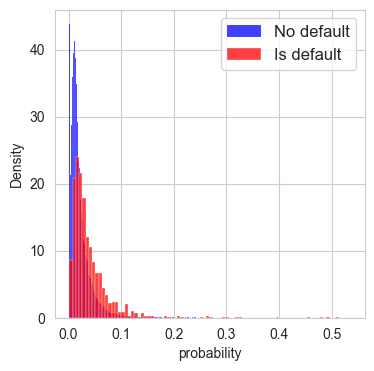

In [224]:
# Realizando a previsão das probabilidades do modelo_baseline
y_score = model_baseline.predict_proba(X_test)[:,1]

# Função para plotar o histograma das probabilidades preditas
def plot_probabilities_hist(y_score, y_test):
    y_result = pd.DataFrame({
        'probability':  y_score,
        'true_class': y_test,
    })
    fig, ax = plt.subplots(figsize=(4, 4))
    negative = y_result.loc[y_result.true_class == 0, 'probability']
    positive = y_result.loc[y_result.true_class == 1, 'probability']
    sns.histplot(negative, stat='density', color='blue', ax=ax, label='No default')
    sns.histplot(positive, stat='density', color='red', ax=ax, label='Is default')
    _ = plt.legend({"No default": negative, "Is default": positive}, fontsize="large")
    plt.show()

plot_probabilities_hist(y_score, y_test)

Verificando o desempenho do modelo

Avg. Precision do modelo baseline 0.05608732724338756
A proporção da classe de interesse (default=1), o baseline da curva do PR é:  0.023635558843324987


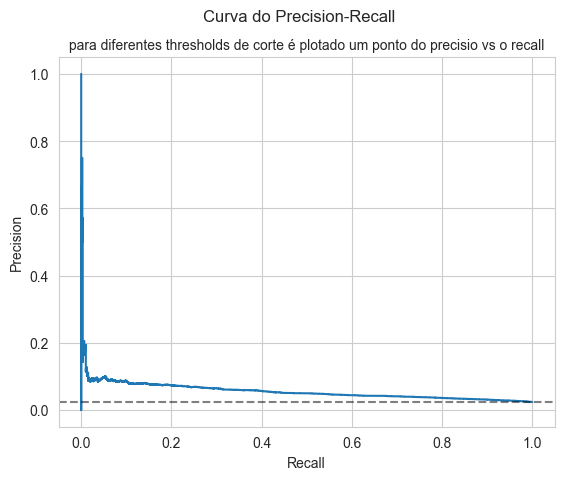

In [241]:
# Verificando o valor do Avg. Preicision https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
avg_precision = average_precision_score(y_test, y_score)
print('Avg. Precision do modelo baseline', average_precision_score(y_test, y_score))
print('A proporção da classe de interesse (default=1), o baseline da curva do PR é: ', default_ratio)

# Computando o precision e o recall para diferentes thresholds
precision,recall,_ = precision_recall_curve(y_test, y_score)

#Plotando a curva do precision vs recall
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
title = 'Curva do Precision-Recall'
subtitle = 'para diferentes thresholds de corte é plotado um ponto do precisio vs o recall'
plt.suptitle(title, y=0.98, fontsize=12)
plt.title(subtitle, fontsize=10)
plt.axhline(default_ratio, linestyle='--', color='black', alpha=0.5)
plt.show()

## Precision, Recall e F1
* **Acurácia**: O quanto o modelo consegue acertar
    * (TP + TN)/ Total
* **recall (sensitivity)**: Do universo dos positivos, quantos o modelo consegue recuperar/encotrar
    * TP/(TP+FN)
* **precision**: Quando o modelo falou que era positivo, quantos eram de fato positivos
    * TP/(TP+FP)
* **F1-measure**: média harmônica entre o precision e o recall

<img src="imgs/confusion_matrix.png" alt="Undersampling vs Oversampling" width="600"/>

[source](https://www.v7labs.com/blog/confusion-matrix-guide)

## Entendendo o Precision e o Recall

## Comparando o LightGBM com diferentes class_weights

Treinando os modelos

In [242]:
# Peso das classes balanceados (o próprio algoritmo calcula o peso ideal)
model_weighted = LGBMClassifier(class_weight='balanced')
model_weighted.fit(X_train, y_train)

# Modelo dando 10 vezes mais peso para a classe 1 (é default)
model_weighted_10 = LGBMClassifier(class_weight={0:1, 1:10})
model_weighted_10.fit(X_train, y_train)

LGBMClassifier(class_weight={0: 1, 1: 10})

Verificando as predições do modelo baseline, observe que esse modelo **tende a dar probabilidades de pertencer a classe default bem maiores** do que baseline

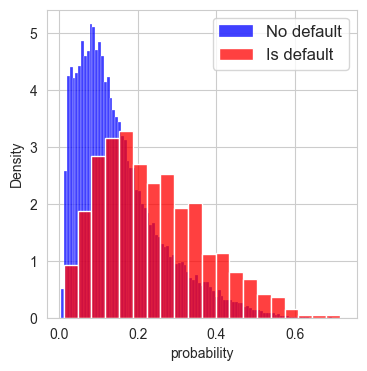

In [244]:
# Realizando a previsão das probabilidades do modelo com a classe minoritaria tendo um peso 10 vezes maior
y_score = model_weighted_10.predict_proba(X_test)[:,1]

# plotando o gráfico das probabilidades
plot_probabilities_hist(y_score, y_test)

Verificando os resultados dos diferentes `class_weight`

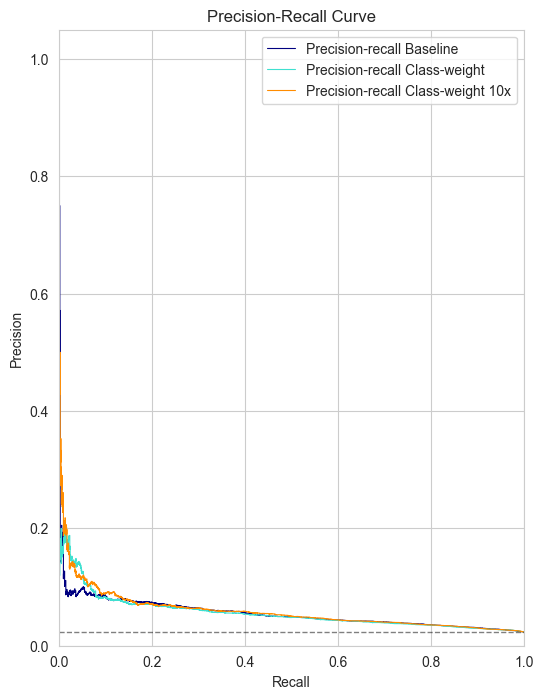

              Model  Avg. Precision
2  Class-weight 10x        0.059790
1      Class-weight        0.056537
0          Baseline        0.056087


In [264]:
# Lista dos modelos
models = [model_baseline, model_weighted, model_weighted_10,]

# Nome dos modelos
models_labels = ['Baseline', 'Class-weight', 'Class-weight 10x']

# Função usada para plotar a curva do Precision-Recall e para retornar o Avg. Precision (AUC), recebendo como input os modelos treinandos e nome desses modelos (labels)
def plot_precision_recall_curve(models, labels):
    # setup plot details
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])
    avg_precisions = []
    _, ax = plt.subplots(figsize=(6, 8))

    # Para cada modelo plotar a curva do Precision-Recall
    for model, label, color in zip(models, labels, colors):
        # Retornando a probabilidade de pertencer a classe 1 (default)
        y_score = model.predict_proba(X_test)[:,1]

        # Computando as métricas
        precision,recall,_ = precision_recall_curve(y_test, y_score)
        avg_precision = average_precision_score(y_test, y_score)
        avg_precisions.append(avg_precision)

        display = PrecisionRecallDisplay(
            recall=recall,
            precision=precision,
            #average_precision=avg_precision,
        )
        display.plot(ax=ax, name=f"Precision-recall {label}", color=color, linewidth=0.8)


    handles, labels = display.ax_.get_legend_handles_labels()
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    plt.axhline(default_ratio, linestyle='--', color='black', alpha=0.5, linewidth=1)

    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Precision-Recall Curve")

    result = pd.DataFrame({
        'Model': models_labels,
        'Avg. Precision': avg_precisions
    })

    plt.show()
    return result.sort_values(by='Avg. Precision', ascending=False)

result = plot_precision_recall_curve(models, models_labels)
print(result)

## Estratégias de Rebalanceamento

<img src="imgs/over_under_sampling.png" alt="Undersampling vs Oversampling"/>

[fonte](https://www.kaggle.com/code/rafjaa/resampling-strategies-for-imbalanced-datasets/notebook)

## Criando datasets de treino balanceados

In [265]:
from collections import Counter

randUnderSampler = RandomUnderSampler(random_state=42)
X_rus, y_rus = randUnderSampler.fit_resample(X_train, y_train)

randOverSampler = RandomOverSampler(random_state=42)
X_ros, y_ros = randOverSampler.fit_resample(X_train, y_train)

print('Dataset de treino Original: ', Counter(y_train))
print('Dataset de treino com Undersample: ', Counter(y_rus))
print('Dataset de treino com Overample: ', Counter(y_ros))

Dataset de treino Original:  Counter({0.0: 112715, 1.0: 2729})
Dataset de treino com Undersample:  Counter({0.0: 2729, 1.0: 2729})
Dataset de treino com Overample:  Counter({0.0: 112715, 1.0: 112715})


## Criando modelos com diferentes técnicas de balanceamento de datasets

In [266]:
# Fit model without random under sampling
model_rus = LGBMClassifier()
model_rus.fit(X_rus, y_rus)

# Fit model without random over sampling
# model_ros = LogisticRegression(max_iter=2000, random_state=42)
model_ros = LGBMClassifier()
model_ros.fit(X_ros, y_ros)

LGBMClassifier()

## Comparando Undersampling versus Oversampling

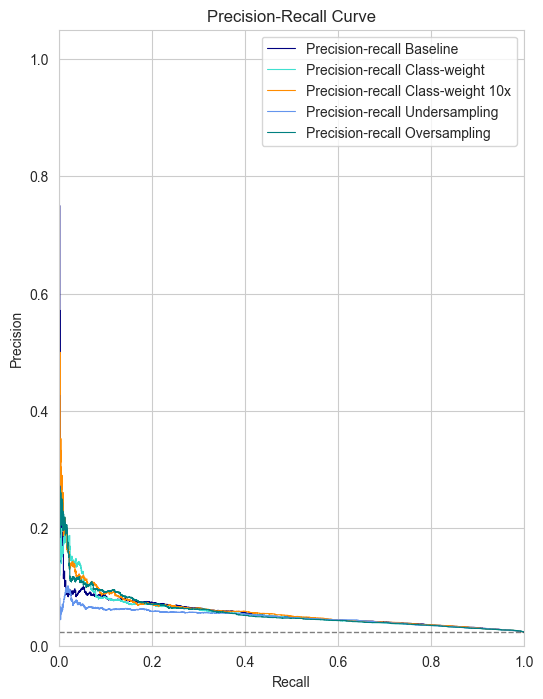

              Model  Avg. Precision
2  Class-weight 10x        0.059790
4      Oversampling        0.057350
1      Class-weight        0.056537
0          Baseline        0.056087
3     Undersampling        0.048201


In [267]:
models = [model_baseline, model_weighted, model_weighted_10, model_rus, model_ros]
models_labels = ['Baseline', 'Class-weight', 'Class-weight 10x', 'Undersampling', 'Oversampling']

result = plot_precision_recall_curve(models, models_labels)

print(result)

## SMOTE
* SMOTE (Synthetic Minority Over-sampling Technique) é uma técnica de oversampling
* Ela funciona criando sinteticamente novos exemplos da classe minoritária, baseando-se nos exemplos existentes da classe.
* Isso é feito escolhendo aleatoriamente um exemplo da classe minoritária e encontrando o seu k-vizinho mais próximo.
* Então, um novo exemplo é criado adicionando uma pequena quantidade de variação entre o exemplo escolhido e seu vizinho mais próximo.
* Isso ajuda a aumentar a representatividade da classe minoritária no conjunto de dados.

<img src="imgs/smote.png" alt="SMOTE" width="600"/>

source: https://www.youtube.com/watch?v=adHqzek--d0


## Criando um modelo usando SMOTE

In [288]:
smote = SMOTE(sampling_strategy=0.2)
#smote = SMOTE(random_state=42)
X_smt, y_smt = smote.fit_resample(X_train, y_train)
print('Dataset de treino com SMOTE overample: ', Counter(y_smt))

model_smote = LGBMClassifier()
model_smote.fit(X_smt, y_smt)

Dataset de treino com SMOTE overample:  Counter({0.0: 112715, 1.0: 22543})


LGBMClassifier()

## Comparando todas as abordagens

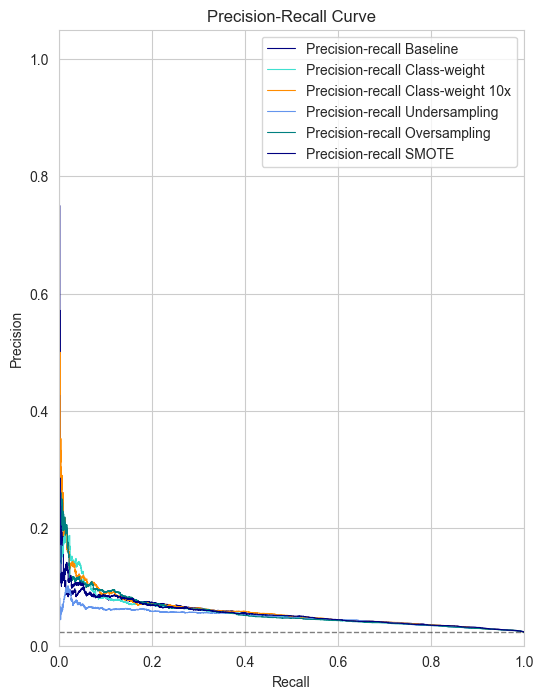

              Model  Avg. Precision
2  Class-weight 10x        0.059790
4      Oversampling        0.057350
1      Class-weight        0.056537
0          Baseline        0.056087
5             SMOTE        0.055029
3     Undersampling        0.048201


In [289]:
models = [model_baseline, model_weighted, model_weighted_10, model_rus, model_ros, model_smote]
models_labels = ['Baseline', 'Class-weight', 'Class-weight 10x', 'Undersampling', 'Oversampling', 'SMOTE']

result = plot_precision_recall_curve(models, models_labels)

print(result)

# Vatagens e desvatagens das técnicas de balanceamento

**Vantagens do Undersampling:**

* Redução do tempo de treinamento do modelo
* Redução do espaço de memória necessário para armazenar os dados
* Prevenção de sobreajuste (overfitting)

**Desvantagens do Undersampling:**

* Perda de informações importantes presentes nas amostras removidas
* Aumento do risco de subrepresentação de algumas classes

**Vantagens do Oversampling:**

* Aumento da representatividade de classes desbalanceadas
* Prevenção de subrepresentação de algumas classes

**Desvantagens do Oversampling:**

* Aumento do tempo de treinamento do modelo
* Aumento do espaço de memória necessário para armazenar os dados
* Aumento do risco de sobreajuste (overfitting)

**Vantagens do SMOTE Oversampling:**

* Aumento da representatividade de classes desbalanceadas sem criar cópias exatas das amostras existentes
* Criação de novos exemplos sintéticos que podem ajudar a melhorar a generalização do modelo
* Prevenção de subrepresentação de algumas classes

**Desvantagens do SMOTE Oversampling:**

* Aumento do tempo de treinamento do modelo
* Aumento do espaço de memória necessário para armazenar os dados
* Aumento do risco de sobreajuste (overfitting)
* A criação de exemplos sintéticos pode não refletir a distribuição real dos dados e pode levar a resultados falsos.

**Vantagens do Class Weight:**

* Permite ajustar a importância das diferentes classes durante o treinamento do modelo
* Ajuda a lidar com problemas de desequilíbrio de classes sem precisar realizar oversampling ou undersampling
* Melhora a precisão do modelo para classes sub-representadas

**Desvantagens do Class Weight:**
* Pode levar a sobreajuste (overfitting) se os pesos são ajustados de forma inadequada
* Pode ser difícil encontrar os pesos ideais para cada classe
* Pode não ser uma solução eficaz se o desequilíbrio de classes for muito elevado
* Pode não ser uma solução eficaz se o modelo não tem capacidade para lidar com desequilíbrio de classes.

## Desempenho final do modelo vencedor

In [294]:
# Computando as probabilidade de ser inadimplente (default=1)
y_score = model_weighted_10.predict_proba(X_test)[:,1]
print('Probabilidades da class positiva: ', y_score)

# Computando o precision e recall o para diferentes threshold
precision,recall, thresholds = precision_recall_curve(y_test, y_score)
avg_precision = average_precision_score(y_test, y_score)

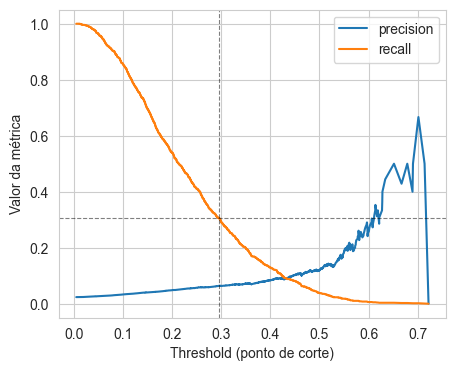

In [363]:
fig, ax = plt.subplots(figsize=(5, 4))

sns.lineplot(x=thresholds, y=precision[:-1], label='precision')
sns.lineplot(x=thresholds, y=recall[:-1], label='recall')

ax.set_ylabel('Valor da métrica')
ax.set_xlabel('Threshold (ponto de corte)')

plt.axvline(0.295, linestyle='--', color='black', alpha=0.5, linewidth=0.8)

plt.axhline(0.30624465355004277, linestyle='--', color='black', alpha=0.5, linewidth=0.8)

#plt.plot([0, 0.295], [0.30624465355004277, 0.295], 'k-')

plt.show()

## (Bônus) Métricas de avaliação do modelo, resolvendo o problema (1) do case
O classificador que se adequaria ao requisito de negócio (problema 1) seria um com o threshold de corte de 0.295. Ou seja:
* O requerente é classificado como *default* (default=1) se sua probabilidade de deafult for maior ou igual a 0.295, `y_score>=0.295`
* Caso contrário como *não default* (default=0), `y_score<0.295`

Com esse ponto de corte para classificar em *default* ou *não default*, o modelo teria um **recall** (habilidade de encontrar a classe de interesse) de **30%**, porém o seu precision seria de apenas **6%**. Ou seja, para todo mundo que o modelo classificar como *default*, apenas **6%** de fato serão *default*.

In [369]:
# Transformando as probabilidades em classes
y_pred = (y_score >= 0.295).astype(int)
print('Predicoes da classe (threshold 0.3): ', y_pred)
print('Proporção de classificados como positivos (default) pelo modelo', np.bincount(y_pred)[1]/np.bincount(y_pred)[0])

# Computando as métricas após a definição de um threshold de classificação
print()
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1-Score:', f1_score(y_test, y_pred))

Predicoes da classe (threshold 0.3):  [0 0 0 ... 0 0 0]
Proporção de classificados como positivos (default) pelo modelo 0.12796370600036477

Accuracy: 0.8773975786729187
Precision: 0.06378050953144486
Recall: 0.30624465355004277
F1-Score: 0.10557357711589502


## (Bônus) Resolvendo o problema (2) do case
### Computando a perda esperada e o problema da calibração

Não podemos usar o `model_weighted_10` para computar probabilidades reais. Já que, por conta do tratamento do desbalanceamento, a probabilidade dele ficou muito alta, não refletindo uma probabilidade real, funcionando apenas como um bom rankeador de maus e bons pagadores.

"Classificadores bem calibrados são classificadores probabilísticos para os quais a saída do método predict_proba pode ser interpretada diretamente como um nível de confiança." [fonte](https://scikit-learn.org/stable/modules/calibration.html)

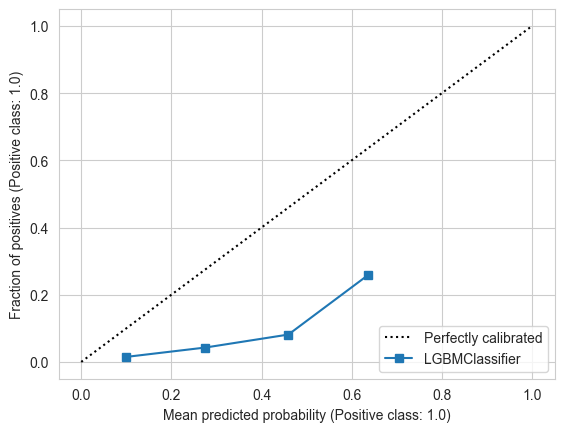

In [371]:
from sklearn.calibration import CalibrationDisplay

# Plotando o gráfico de calibração do modelo model_weighted_10
disp = CalibrationDisplay.from_estimator(model_weighted_10, X_test, y_test)

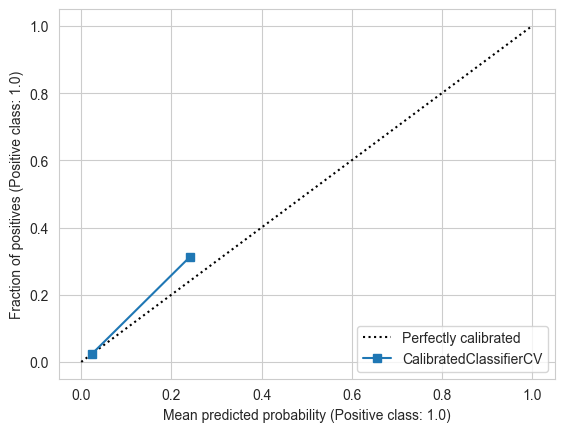

In [372]:
from sklearn.calibration import CalibratedClassifierCV

# Recalibrando o modelo usando o CalibratedClassifierCV do Sklearn
calibrated_model = CalibratedClassifierCV(model_weighted_10, cv="prefit")
calibrated_model.fit(X_test, y_test)

# Plotando o gráfico de calibração do modelo calibrated_model
disp = CalibrationDisplay.from_estimator(calibrated_model, X_test, y_test)

## Computando a perda esperada
Suposição simples para efeitos didáticos: a próxima safra de requerentes terá um tamanho e distribuição de variáveis semelhante ao da amostra de teste (`X_test`)

In [368]:
import locale
locale.setlocale( locale.LC_ALL, '' )

# Computando as probabildiades do modelo model_weighted_10 e do modelo calibrado
y_scores = model_weighted_10.predict_proba(X_test)[:,1]
y_scores_calib = calibrated_model.predict_proba(X_test)[:,1]


# Computando as perdas esperadas do modelo model_weighted_10 e do modelo calibrado
losses = (2000*y_score).sum()
losses_calib = (2000*y_scores_calib).sum()

print('Perda esperada (modelo não calibrado', locale.currency(losses, grouping=True ))
print('Perda esperada (modelo calibrado)', locale.currency(losses_calib, grouping=True ))

Perda esperada (modelo não calibrado $15,026,816.82
Perda esperada (modelo calibrado) $2,338,003.33


## Fim